In [1]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [2]:
import xarray as xr
from utils.function_clns import subsetting_pipeline, prepare
import numpy as np

path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/NDVI/archive.eumetsat.int/umarf-gwt/onlinedownload/riccardo7/4859700/temp/time/ndvi_eumetsat.nc"
chunks ={'time': -1, "lat": 250, "lon":250}
ds_ndvi = xr.open_dataset(path, engine="netcdf4", chunks=chunks)

ds_ndvi = subsetting_pipeline(ds_ndvi).rename({"Band1":"ndvi"})
ds_ndvi["ndvi"] = xr.where(ds_ndvi["ndvi"]==255, np.NaN, ds_ndvi["ndvi"])
ndvi = ds_ndvi["ndvi"]/100

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [3]:
import pandas as pd
import xesmf as xe
ndvi = prepare(ndvi)

regridder = xe.Regridder(ndvi, dataset, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(ndvi)
ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(dataset.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
dataset['time'] = pd.to_datetime(dataset['time'].values, format='%Y-%m-%d')
dataset['time'] =  dataset.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], dataset['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered_1 = dataset.sel(time=common_times)
ds_2_filtered_1 = ds_reprojected.sel(time=common_times)

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(0.043782177927351104, 0.04378217792735114)
(0.043782177927351104, 0.04378217792735114)


In [4]:
import xskillscore as xs
corr_1 = xs.pearson_r(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)
rmse_1 = xs.rmse(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)
mae_1 = xs.mae(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)
mape_1 = xs.mape(ds1_filtered_1, ds_2_filtered_1, dim="time", skipna=True)

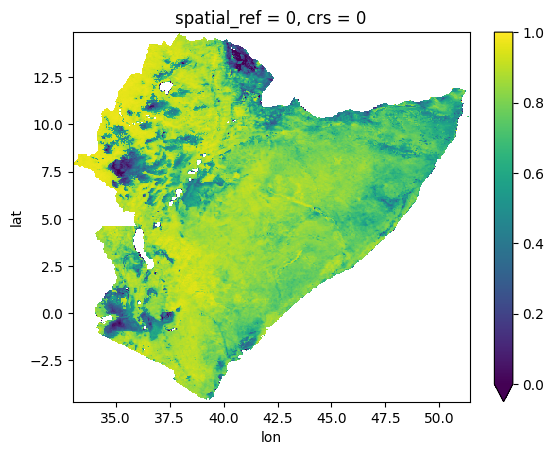

In [8]:
corr_1.transpose("lat","lon").plot(vmin=0)

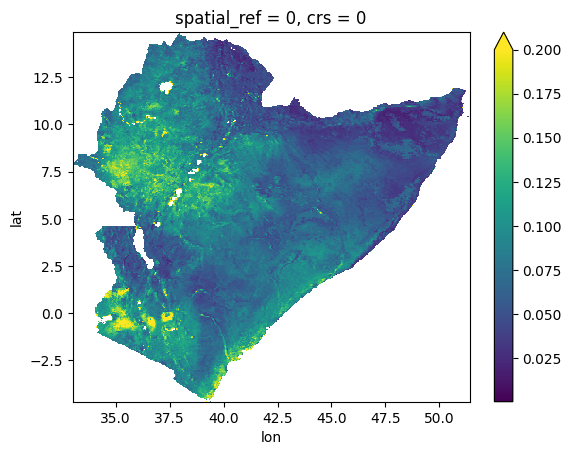

In [11]:
rmse_1.transpose("lat","lon").plot(vmax=0.2)

In [12]:
print("mean correlation is", corr_1.mean().values)
print("mean rmse is", rmse_1.mean().values)
print("mean mae is", mae_1.mean().values)
print("mean mape is", mape_1.mean().values)

mean correlation is 0.76396963157066
mean rmse is 0.07884886263440524
mean mae is 0.06757304910504819
mean mape is 0.36486936450701807


### LAI

In [ ]:
from utils.function_clns import config 
import os
import xarray as xr

chunks ={'time': -1, "lat": 250, "lon":250}

path_lai = config["LAI"]["path"]
lai = xr.open_mfdataset(os.path.join(path_lai, "*.nc"), chunks=chunks)

from utils.function_clns import subsetting_pipeline
lai_ds = subsetting_pipeline(lai)

import pandas as pd
import xesmf as xe
lai_ds = prepare(lai_ds)

regridder = xe.Regridder(dataset, lai_ds, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(dataset)
#ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(lai_ds.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
lai_ds = lai_ds.drop_duplicates(dim=["time"])

#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
lai_ds['time'] = pd.to_datetime(lai_ds['time'].values, format='%Y-%m-%d')
lai_ds['time'] =  lai_ds.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], lai_ds['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered = lai_ds.sel(time=common_times).chunk(chunks)
ds2_filtered = ds_reprojected.sel(time=common_times).chunk(chunks)

## NDVI 10

In [10]:
import xarray as xr 
import os
from vegetation.preprocessing.ndvi_clean import load_landsaf_ndvi

path = "/media/BIFROST/N2/Riccardo/output"
target_store = "output_file.zarr"
zarr_path = os.path.join(path, target_store)
ds = load_landsaf_ndvi(zarr_path)

ERROR:fiona._env:PROJ: proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


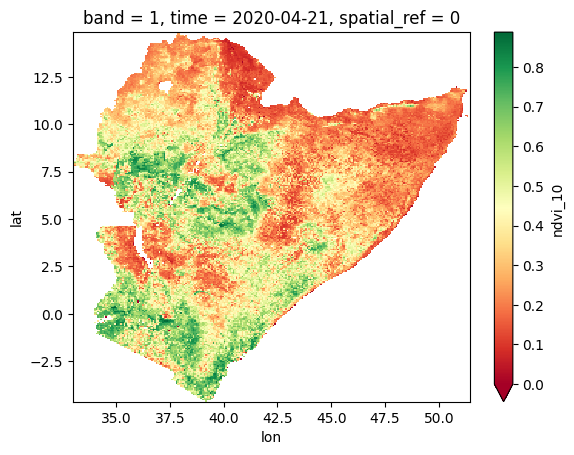

In [43]:
import numpy as np
ds.ndvi_10.isel(time=443).plot(cmap="RdYlGn", vmin=0)

In [11]:
import pandas as pd

def group_into_dekads(date_list):
    result = []
    
    # Sort the list of dates to ensure correct grouping
    sorted_dates = [pd.to_datetime(t) for t in sorted(date_list)]

    threshold_days = [1, 11, 21]
    
    # Group dates into dekads
    current_dekad = []
    for idx in range(len(sorted_dates) - 1):  # Iterate up to the second-to-last element
        date = sorted_dates[idx]
        current_dekad.append(date)
        next_day = sorted_dates[idx+1].day
        if next_day in threshold_days:
            result.append(current_dekad)
            current_dekad = []

    # Handle the last element separately
    last_date = sorted_dates[-1]
    current_dekad.append(last_date)
    result.append(current_dekad)
    
    return result

In [12]:
time_values = dataset["time"].values
list_dates = group_into_dekads(time_values)

final_dataset = None

for date in list_dates:
    # Perform the operation on the subset of the dataset for the current date
    temp_ds = dataset.sel(time=date).max(["time"])
    temp_ds["time"] = date[0]

    # Append the resulting dataset to the final dataset
    if final_dataset is None:
        final_dataset = temp_ds
    else:
        final_dataset = xr.concat([final_dataset, temp_ds], dim="time")

# Optionally, you can sort the final dataset by time
final_dataset = final_dataset.sortby("time")

In [13]:
import pandas as pd
import xesmf as xe
from utils.function_clns import prepare

print(final_dataset.rio.resolution())
print(ds.rio.resolution())

chunks ={'time': -1, "lat": 250, "lon":250}


repr_ds = prepare(final_dataset)
regridder = xe.Regridder(repr_ds, ds, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(repr_ds)
#ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(ds.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
ds = ds.drop_duplicates(dim=["time"])

#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
ds['time'] = pd.to_datetime(ds['time'].values, format='%Y-%m-%d')
ds['time'] =  ds.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], ds['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered = ds.sel(time=common_times).chunk(chunks)
ds2_filtered = ds_reprojected.sel(time=common_times).chunk(chunks)
ds2_filtered = xr.where(ds1_filtered.ndvi_10.isnull(), np.NaN, ds2_filtered)

(0.043782177927351104, 0.04378217792735114)
(0.07142857120000003, -0.0714285712)


ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(0.07142857120000003, -0.0714285712)
(0.07142857120000003, -0.0714285712)


In [8]:
import xskillscore as xs
corr_10 = xs.pearson_r(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)
rmse_10 = xs.rmse(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)
mae_10 = xs.mae(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)
mape_10 = xs.mape(ds1_filtered.ndvi_10, ds2_filtered, dim="time", skipna=True)

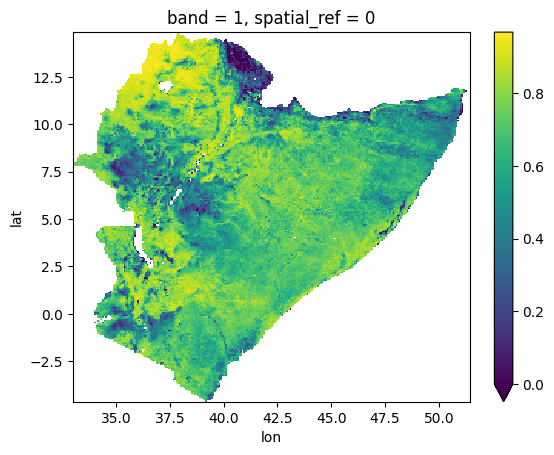

In [76]:
corr_10.plot(vmin=0)

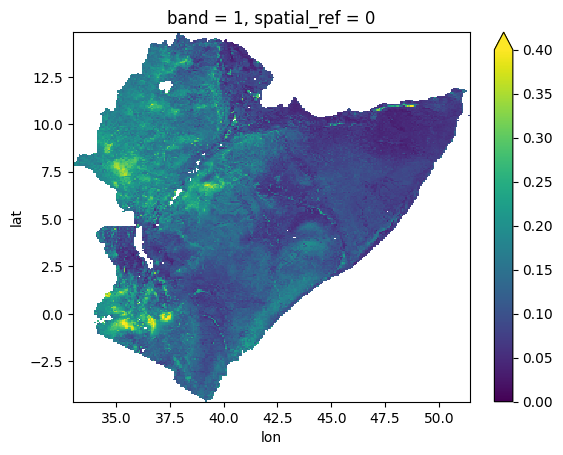

In [14]:
rmse_10.plot(vmax=0.4, vmin=0)

In [77]:
print("mean correlation is", corr_10.mean().values)
print("mean rmse is", rmse_10.mean().values)
print("mean mae is", mae_10.mean().values)
print("mean mape is", mape_10.mean().values)

mean correlation is 0.6526177634723305
mean rmse is 0.12645859254248823
mean mae is 0.11343121467598581
mean mape is 240.59975465053853


### Time series

In [12]:
ndvi_seviri_mean = ds1_filtered_1.mean(["lat","lon"]) ## ours
ndvi_eumetsat_mean = ds_2_filtered_1.mean(["lat","lon"]) ## eumetsat ndvi

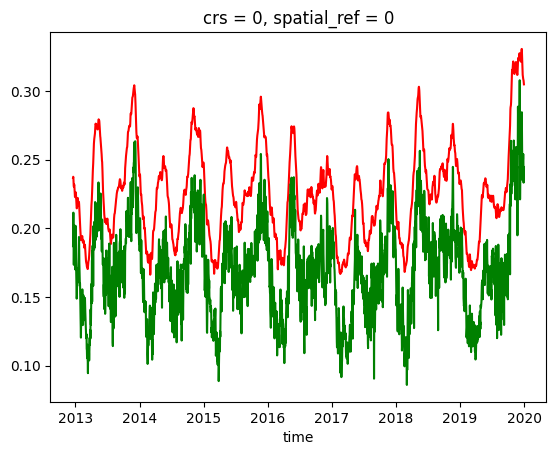

In [13]:
ndvi_seviri_mean.plot(color="red")
ndvi_eumetsat_mean.plot(color="green")

In [15]:
ndvi_10_lsaf = ds1_filtered.ndvi_10.mean(["lat","lon"]) ## landsaf ndvi
ndvi_10 = ds2_filtered.mean(["lat","lon"]) ## ours ndvi 10 days

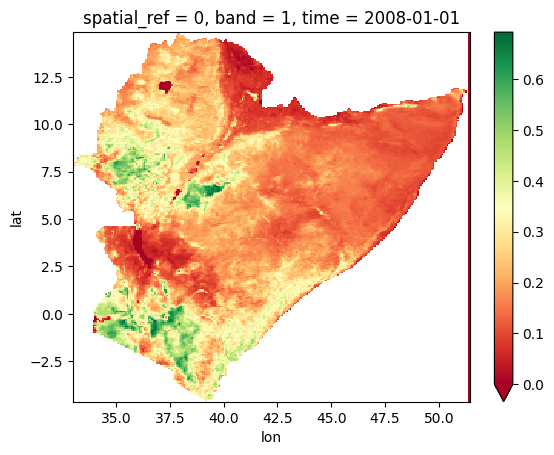

In [47]:
ds2_filtered.isel(time=0).plot(vmin=0, cmap="RdYlGn")

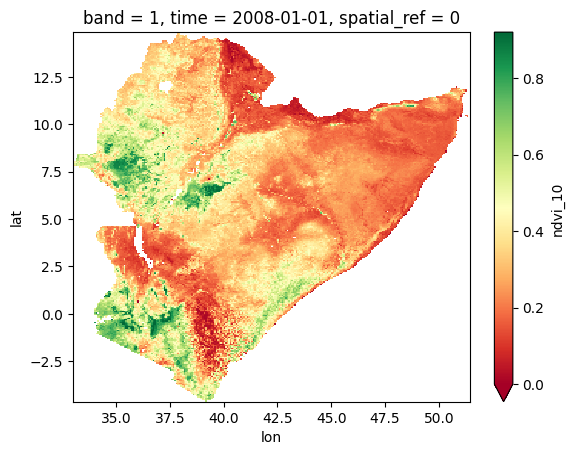

In [62]:
ds1_filtered.ndvi_10.isel(time=0).plot(vmin=0, cmap="RdYlGn")

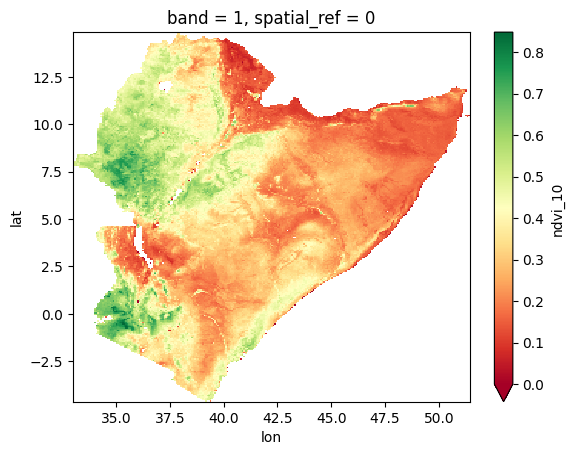

In [28]:
ds.ndvi_10.mean(["time"]).plot(vmin=0, cmap="RdYlGn")

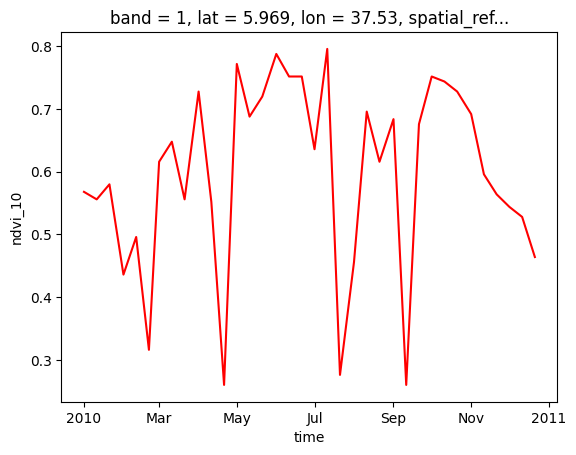

In [24]:
time_min="2010-01-01"
time_max="2010-12-31"
lat = 6
lon= 37.5

ds.ndvi_10.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")

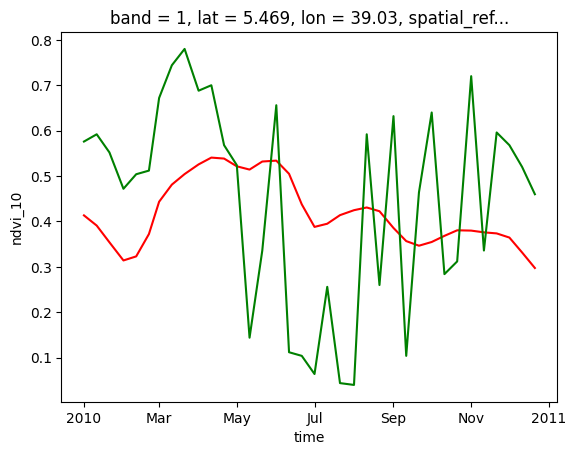

In [29]:
time_min="2010-01-01"
time_max="2010-12-31"
lat = 5.5
lon= 39
ds2_filtered.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")
ds1_filtered.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).ndvi_10.plot(color="green")

In [21]:
from vegetation.analysis.NDVI_indices import compute_vci

vci_lsaf = compute_vci(ds1_filtered.ndvi_10)
vci_ours = compute_vci(ds2_filtered)

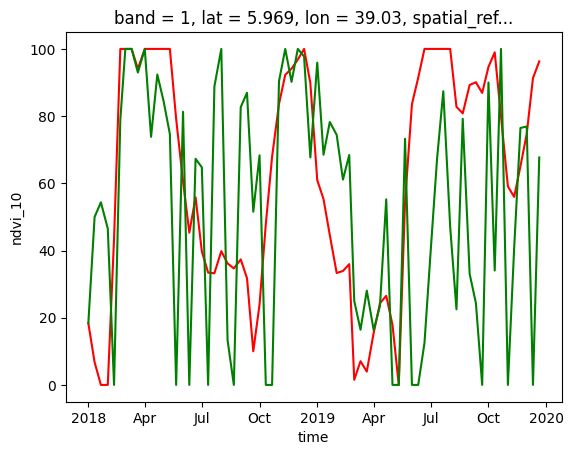

In [27]:
time_min="2018-01-01"
time_max="2019-12-31"
lat = 6
lon= 39
vci_ours.sel(lon=lon, lat = lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="red")
vci_lsaf.sel(lon=lon, lat =lat, method="nearest").sel(time=slice(time_min, time_max)).plot(color="green")

In [14]:
from analysis.visualizations.viz_vci_spi import get_subplot_year, box_plot_year
years = [i for i in np.arange(2008, 2020)]


df_list_1, list_dates_1 = get_subplot_year(ds = ds1_filtered.ndvi_10.to_dataset(name="ndvi"), 
                                        var="ndvi", year=years)

df_list, list_dates = get_subplot_year(ds = ds2_filtered.to_dataset(name="ndvi"), 
                                        var="ndvi", year=years)

days are 366
[########################################] | 100% Completed | 13.42 ss
days are 366
[########################################] | 100% Completed | 12.35 s


In [15]:
def plot_climatology(df_list, list_dates):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(1, 2) 

    # the first subplot
    ax0 = fig.add_subplot(gs[0])
    #ax0.set_title("NDVI for 2009")
    ax0.set_ylabel("NDVI value", fontsize=9)
    ax0.set_xlabel("Day of the year", fontsize=9)

    line0 = ax0.boxplot(df_list, showfliers=False, 
                patch_artist=True, 
                labels=list_dates, 
                showmeans=False,
                medianprops=dict(color="green",ls="--",lw=1), 
                positions=np.arange(0, len(df_list)*0.1, 0.1),
                meanline=True) 
                # meanprops=dict(color="red", ls="-", lw=2))

    n=15
    for ax in [ax0]:
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='grey', linestyle='dashed')
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_gridlines()) if i % n != 0]
        ax.tick_params(labelrotation=45, tick1On=False)

    for med in line0['medians']:
        med.set_color('red')

    for box in line0["boxes"] :
        box.set_color("lightgrey")
        box.set_alpha(0.8)

    for whisk in line0["whiskers"]:
        whisk.set_color("green")

    gs.tight_layout(fig, rect=[0, 0, 1, 0.95])

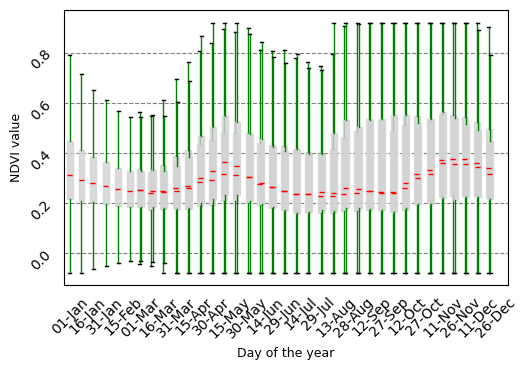

In [16]:
plot_climatology(df_list_1, list_dates_1)

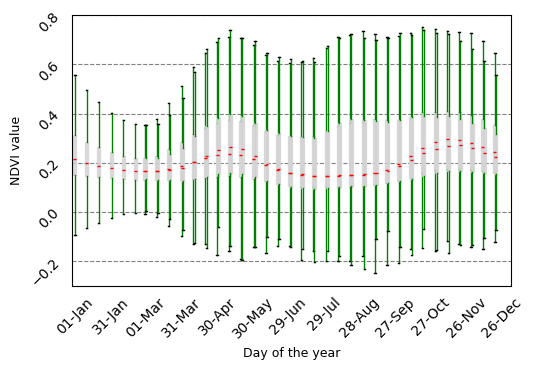

In [49]:
plot_climatology(df_list, list_dates)

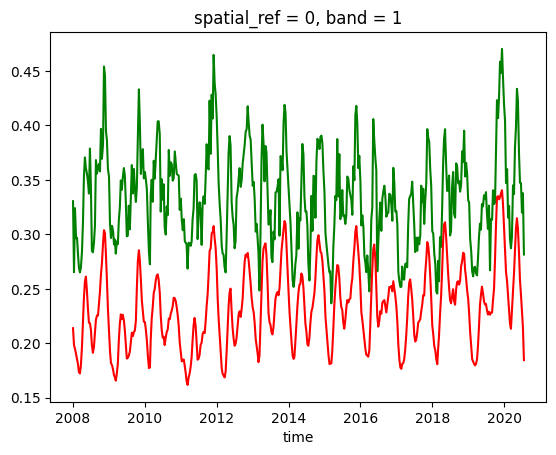

In [16]:
ndvi_10_lsaf.plot(color="green")
ndvi_10.plot(color="red")

In [26]:
import matplotlib.pyplot as plt

def plot_random_points_over_time(data_array1, data_array2):

    lat = data_array1["lat"].values
    lon = data_array1["lon"].values

    def subset_with_random_points():
        # Get random latitude and longitude indices
        random_lat = np.random.choice(lat)
        random_lon = np.random.choice(lon)

        # Extract data for the random points
        random_point_data1 = data_array1.sel(lat=random_lat, lon=random_lon)
        random_point_data2 = data_array2.sel(lat=random_lat, lon=random_lon)
        return random_point_data1, random_point_data2, random_lat, random_lon
    
    random_point_data1, random_point_data2, random_lat, random_lon = subset_with_random_points()

    while random_point_data1.isnull().all() == True:
        random_point_data1, random_point_data2, random_lat, random_lon = subset_with_random_points()

    # Create a time array
    time = data_array1.time.values

    # Plot the random points over time
    plt.figure(figsize=(10, 6))
    plt.plot(time, random_point_data1, label='Reference', marker='o', color="green")
    plt.plot(time, random_point_data2, label='Calculated', marker='o',color="red")

    # Add labels and legend
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f"Lat {round(random_lat,2)} Lon {round(random_lon,2)} Over Time")
    plt.legend()

    # Show the plot
    plt.show()

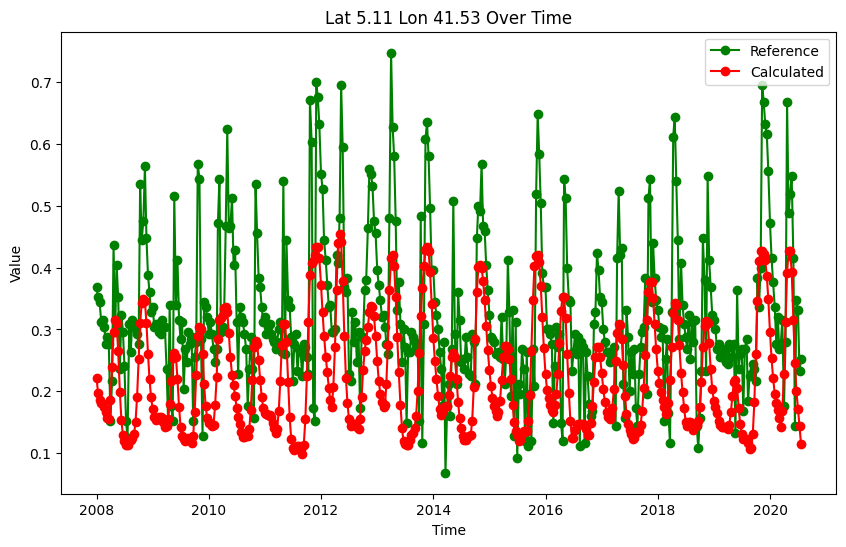

In [27]:
plot_random_points_over_time(ds1_filtered.ndvi_10, ds2_filtered)

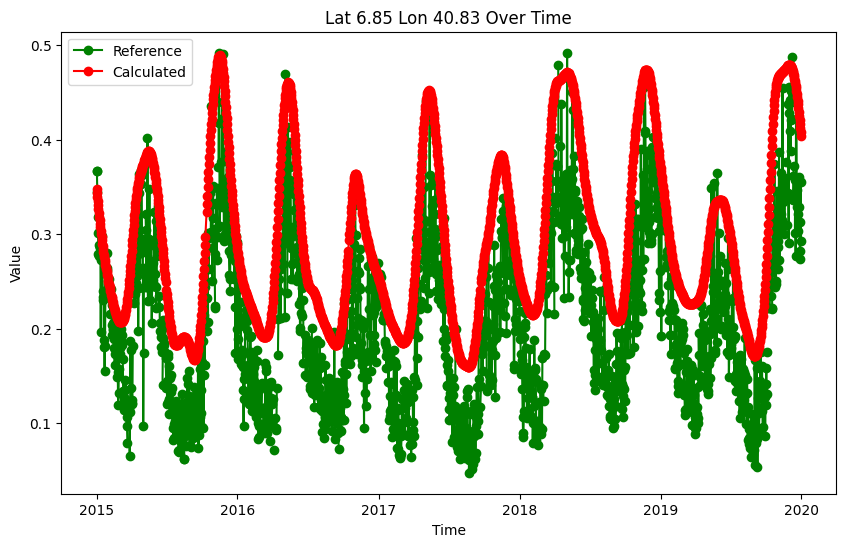

In [62]:
time_min = "2015-01-01"
time_max = "2019-12-31"

plot_random_points_over_time(ds_2_filtered_1.sel(time=slice(time_min, time_max)), 
                             ds1_filtered_1.sel(time=slice(time_min, time_max)))

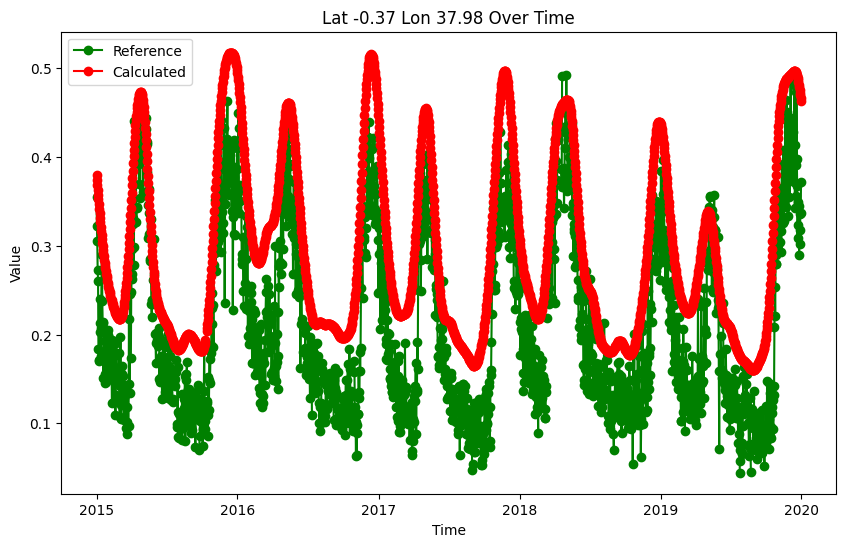

In [64]:
time_min = "2015-01-01"
time_max = "2019-12-31"

plot_random_points_over_time(ds_2_filtered_1.sel(time=slice(time_min, time_max)), 
                             ds1_filtered_1.sel(time=slice(time_min, time_max)))

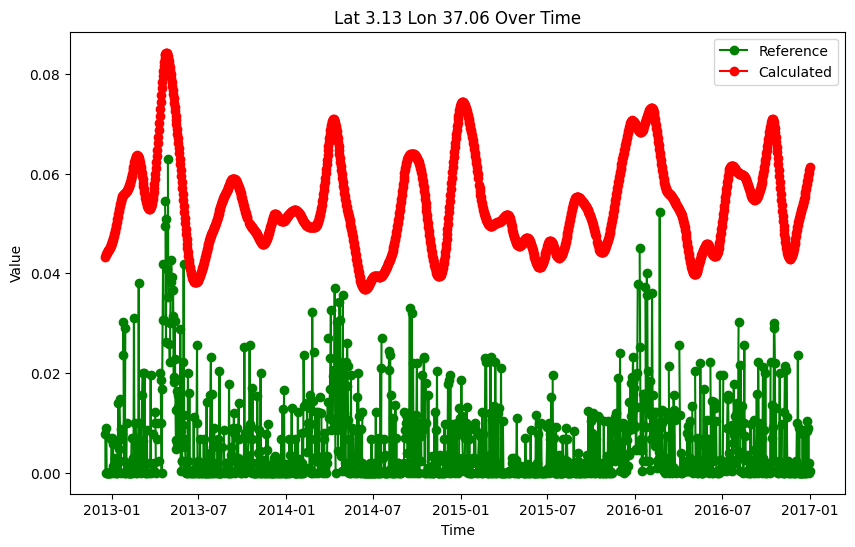

In [88]:
time_min = "2012-01-01"
time_max = "2016-12-31"

plot_random_points_over_time(ds_2_filtered_1.sel(time=slice(time_min, time_max)), 
                             ds1_filtered_1.sel(time=slice(time_min, time_max)))

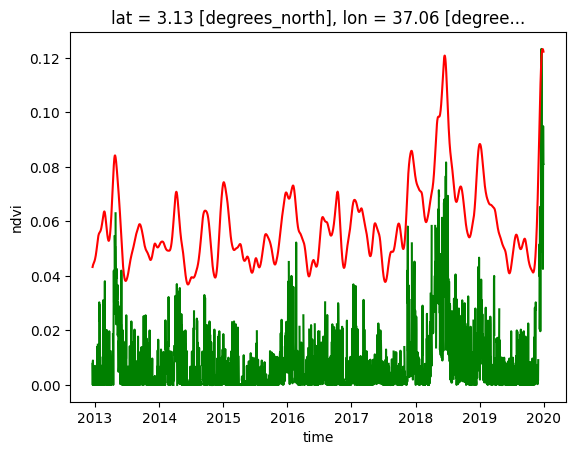

In [13]:
lat = 3.13
lon = 37.06

ds_2_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="green")
ds1_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="red")

### Another lat lon point with good smoothing in the area with high rmse

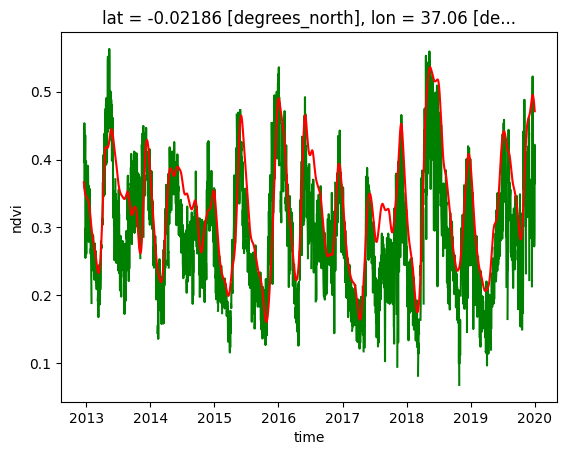

In [14]:
lat = 0
lon = 37.06

ds_2_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="green")
ds1_filtered_1.sel(lat=lat, lon=lon, method="nearest").plot(color="red")

### Max NDVI

In [5]:
import xarray as xr
from utils.function_clns import subsetting_pipeline, prepare
import numpy as np
import warnings
warnings.filterwarnings('ignore')


path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/NDVI/archive.eumetsat.int/umarf-gwt/onlinedownload/riccardo7/4859700/temp/max//time/*.nc"
chunks ={'time': 50, "lat": 250, "lon":250}
ds_ndvi = xr.open_mfdataset(path, engine="netcdf4", chunks=chunks)

ds_ndvi = subsetting_pipeline(ds_ndvi).rename({"Band1":"ndvi"})
ds_ndvi["ndvi"] = xr.where(ds_ndvi["ndvi"]==255, np.NaN, ds_ndvi["ndvi"])
max_ndvi = ds_ndvi["ndvi"]/100

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [ ]:
filename = "seviri_daily_maxndvi.nc"
compression = {"ndvi" :{'zlib': True, "complevel":4}}
from utils.function_clns import config
max_ndvi.to_dataset(name="ndvi").to_netcdf(os.path.join(config["NDVI"]["ndvi_path"],filename),
             encoding=compression)

In [130]:
np.unique(max_ndvi.values)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ,  nan], dtype=float32)

(array([2.7186247e+07, 9.3087595e+07, 5.3918899e+07, 3.0441701e+07,
        2.2172990e+07, 1.5567478e+07, 7.0002550e+06, 4.1576500e+05,
        2.3340000e+03, 2.3848000e+04]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

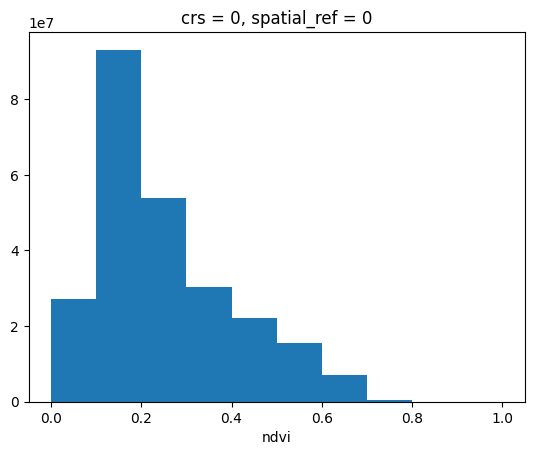

In [131]:
max_ndvi.plot()

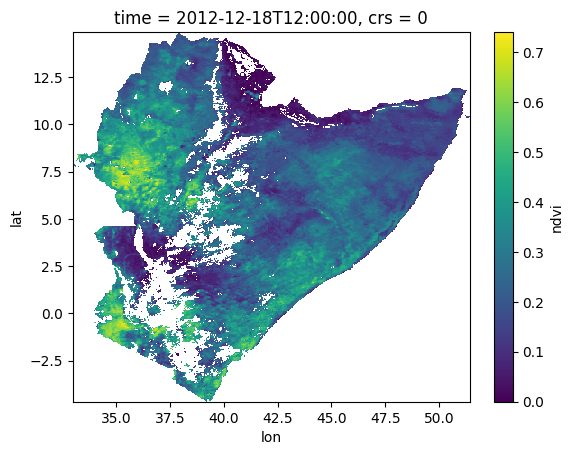

In [7]:
max_ndvi.isel(time=0).plot()

In [6]:
import pandas as pd
import xesmf as xe
max_ndvi = prepare(max_ndvi)

regridder = xe.Regridder(max_ndvi, dataset, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(max_ndvi)
ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(dataset.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
dataset['time'] = pd.to_datetime(dataset['time'].values, format='%Y-%m-%d')
dataset['time'] =  dataset.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], dataset['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered_max = dataset.sel(time=common_times).chunk({"time": -1, "lat":50, "lon":50})
ds_2_filtered_max = ds_reprojected.sel(time=common_times).chunk({"time":-1, "lat":50, "lon":50})

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(0.043782177927351104, 0.04378217792735114)
(0.043782177927351104, 0.04378217792735114)


In [24]:
import xskillscore as xs
corr_max = xs.pearson_r(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)
rmse_max = xs.rmse(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)
mae_max = xs.mae(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)
mape_max = xs.mape(ds1_filtered_max, ds_2_filtered_max, dim="time", skipna=True)

In [25]:
print("mean correlation is", corr_max.mean().values)
print("mean rmse is", rmse_max.mean().values)
print("mean mae is", mae_max.mean().values)
print("mean mape is", mape_max.mean().values)

mean correlation is 0.8104107238495506
mean rmse is 0.0547695524554307
mean mae is 0.042309953356324204
mean mape is 0.2673553359304233


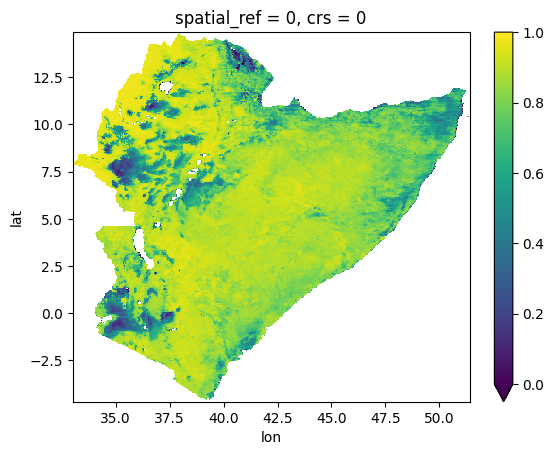

In [30]:
corr_max.transpose("lat","lon").plot(vmin=0)

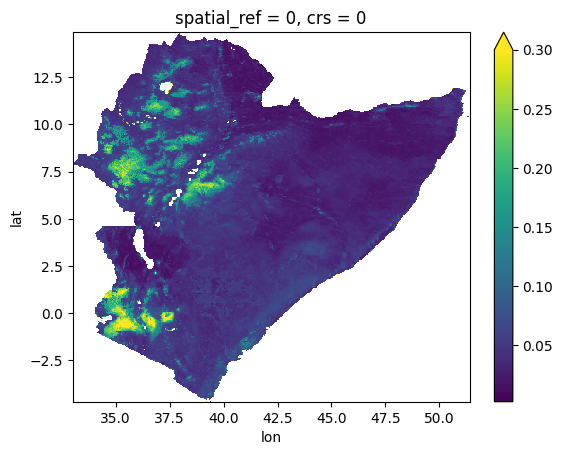

In [32]:
rmse_max.transpose("lat","lon").plot(vmax=0.3)

#### Modifying NDVI max 

In [120]:
# Sample calculation function
def apply_ndvi_conversion(ndvi_data):
    ndvi_data[np.isnan(ndvi_data)] = -2
    ndvi_data = np.floor((ndvi_data + 1) * 128)  # [-1 1] -> [0 256]
    ndvi_data[ndvi_data > 255] = 255
    ndvi_data[ndvi_data < 0] = 0
    return np.uint8(ndvi_data)  # change data type from double to uint8

def scale_ndvi(ndvi):
    scaled_ndvi = ((ndvi + 1) * 127)
    scaled_ndvi = xr.where(scaled_ndvi.isnull(), 255, scaled_ndvi)
    return scaled_ndvi.astype(int)

# Apply the function to the NDVI data variable in the dataset
# Create a new dataset with the transformed NDVI values
ds_transformed = dataset.copy()

ds_converted= scale_ndvi(ds_transformed)
ds_converted = xr.where(ds_converted==255, np.NaN, ds_converted)
ds_converted = (ds_converted/254)

(array([4.40500000e+04, 3.44020000e+05, 9.85992000e+05, 8.65928100e+06,
        2.91579458e+08, 1.61514868e+08, 7.97017810e+07, 2.63341030e+07,
        1.68613000e+05, 1.00000000e+01]),
 array([0.19685039, 0.27598425, 0.35511811, 0.43425197, 0.51338583,
        0.59251969, 0.67165354, 0.7507874 , 0.82992126, 0.90905512,
        0.98818898]),
 <BarContainer object of 10 artists>)

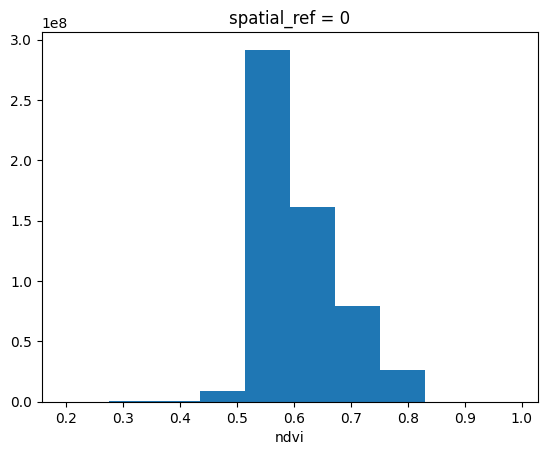

In [128]:
ds_converted.plot()

In [151]:
norm_ndvi = (ds1_filtered_max - ds1_filtered_max.min())/(ds1_filtered_max.max() - ds1_filtered_max.min())
zero_ndvi = xr.where(ds1_filtered_max < 0, 0, ds1_filtered_max)

### Calculate histogram differences
diff_ndvi = ds_converted - ds_2_filtered_max
diff_ndvi_orig = ds1_filtered_max - ds_2_filtered_max
diff_ndvi_norm = norm_ndvi - ds_2_filtered_max
diff_zero_ndvi = zero_ndvi - ds_2_filtered_max

(array([6.40000000e+01, 8.71400000e+03, 1.48560000e+04, 5.33472000e+05,
        2.55731100e+06, 1.72778320e+07, 1.92829278e+08, 3.23193000e+06,
        1.31672000e+05, 3.15400000e+03]),
 array([-1.12747836, -0.95234931, -0.77722025, -0.60209119, -0.42696211,
        -0.25183305, -0.07670399,  0.09842508,  0.27355415,  0.4486832 ,
         0.62381226]),
 <BarContainer object of 10 artists>)

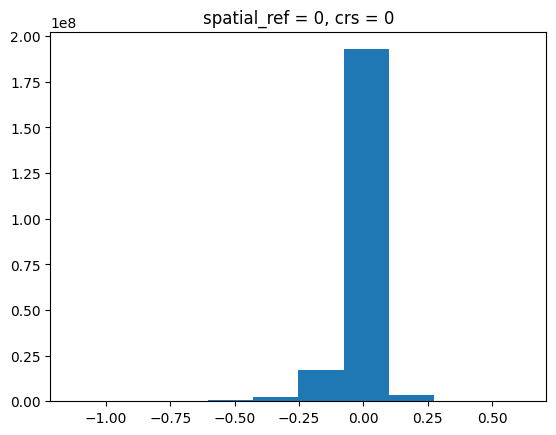

In [143]:
diff_ndvi_orig.plot() ## no modification

(array([6.20700000e+03, 5.97800000e+03, 1.33452000e+05, 1.16610300e+06,
        3.80605000e+06, 7.43223880e+07, 1.35699293e+08, 1.36086500e+06,
        8.57700000e+04, 2.17700000e+03]),
 array([-1.        , -0.83761877, -0.67523754, -0.5128563 , -0.3504751 ,
        -0.18809387, -0.02571264,  0.13666858,  0.29904979,  0.46143103,
         0.62381226]),
 <BarContainer object of 10 artists>)

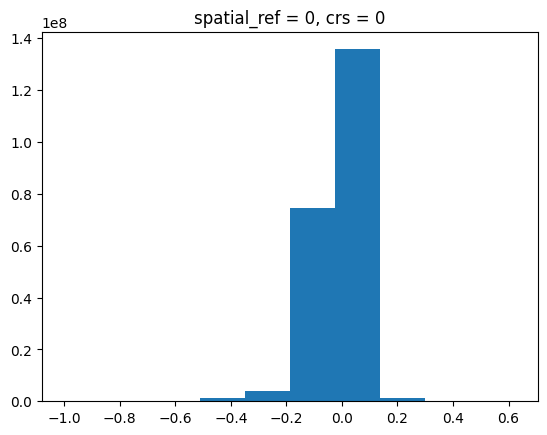

In [152]:
diff_zero_ndvi.plot() ### imputing to zero all the negative values

(array([7.77000000e+02, 9.34300000e+03, 1.22310000e+04, 4.92321000e+05,
        2.70346100e+06, 2.08474070e+07, 1.62760316e+08, 2.95757840e+07,
        1.82439000e+05, 4.20400000e+03]),
 array([-0.65808892, -0.50532812, -0.35256726, -0.19980644, -0.04704561,
         0.10571522,  0.25847605,  0.41123688,  0.56399769,  0.71675855,
         0.86951935]),
 <BarContainer object of 10 artists>)

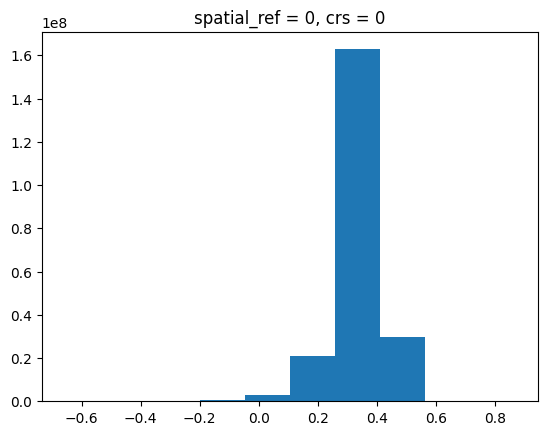

In [148]:
diff_ndvi_norm.plot()  ### normalizing NDVI from 0 to 1

(array([4.63700000e+03, 6.99500000e+03, 1.14920000e+04, 5.18247000e+05,
        3.68161300e+06, 2.53787280e+07, 7.99208280e+07, 1.06683361e+08,
        3.77048000e+05, 5.33400000e+03]),
 array([-0.56692913, -0.43010473, -0.29328032, -0.15645592, -0.01963151,
         0.11719289,  0.2540173 ,  0.3908417 ,  0.52766611,  0.66449051,
         0.80131492]),
 <BarContainer object of 10 artists>)

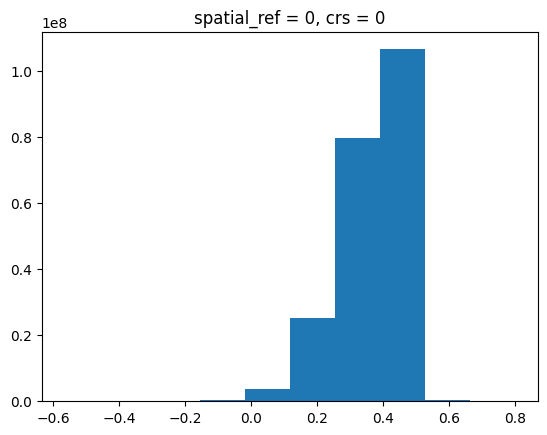

In [140]:
diff_ndvi.plot()  ### converting NDVI to 0-255

#### Checking correspondence between predicted and real max NDVI

In [7]:
# Extract predicted and real values
predicted_values = ds1_filtered_max.values.flatten()
real_values = ds_2_filtered_max.values.flatten()

arr1 = predicted_values[~np.isnan(predicted_values)]
arr2 = real_values[~np.isnan(real_values)]

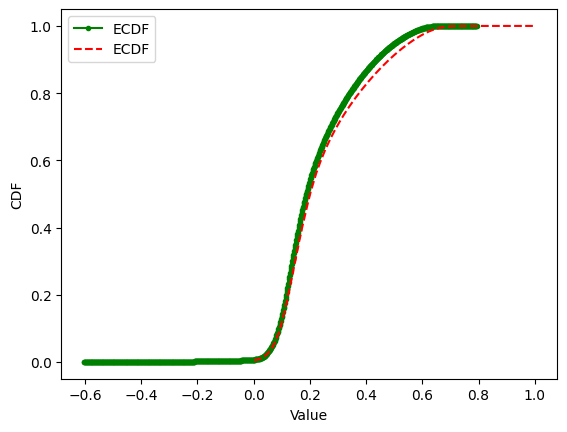

In [16]:
# Create histogram
hist1, bins1 = np.histogram(arr1, bins=1000, density=True)
# Compute cumulative sum
cumulative = np.cumsum(hist1)
# Normalize cumulative sum
ecdf1 = cumulative / np.max(cumulative)

# Create histogram
hist2, bins2 = np.histogram(arr2, bins=1000, density=True)
# Compute cumulative sum
cumulative = np.cumsum(hist2)
# Normalize cumulative sum
ecdf2 = cumulative / np.max(cumulative)


import matplotlib.pyplot as plt

# Plot ECDF
plt.plot(bins1[1:], ecdf1, marker='.', linestyle='-', label='ECDF', color="green")
plt.plot(bins2[1:], ecdf2, linestyle='dashed', label='ECDF', color="red")
plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.show()

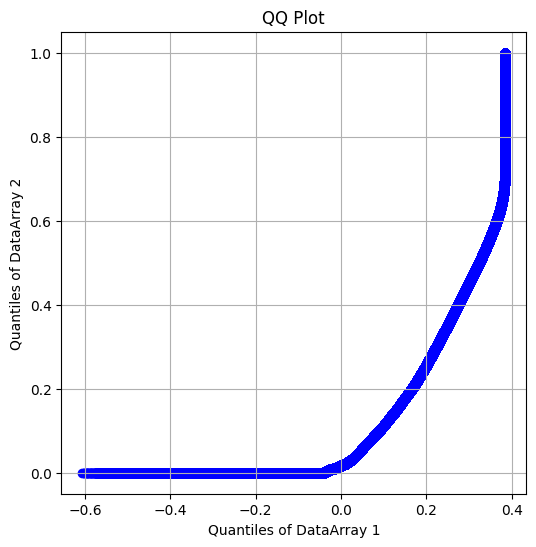

In [160]:
sorted_da1 = np.sort(predicted_values)
sorted_da2 = np.sort(real_values)

# Create a quantile plot
plt.figure(figsize=(6, 6))
plt.scatter(sorted_da1, sorted_da2, color='blue')
plt.xlabel('Quantiles of DataArray 1')
plt.ylabel('Quantiles of DataArray 2')
plt.title('QQ Plot')
plt.grid(True)
plt.show()

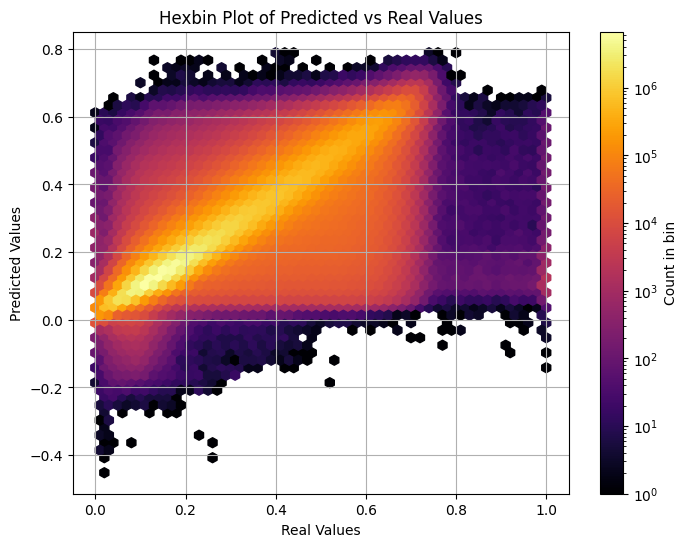

In [159]:
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, bins='log', cmap='inferno')
plt.colorbar(label='Count in bin')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

### Raw vegetation data

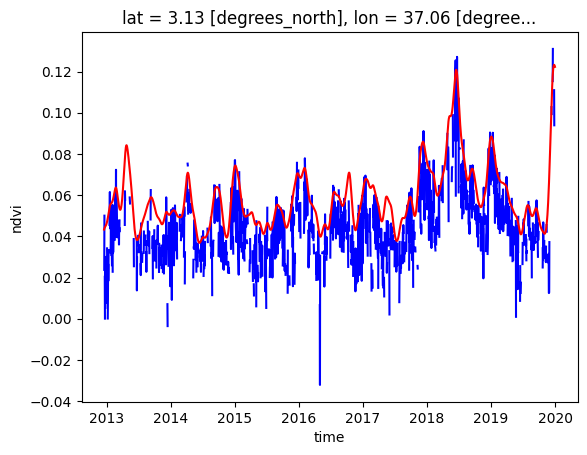

In [15]:
res_xr = xr.open_dataset(os.path.join(
    config["NDVI"]["ndvi_prep"],"final_ndvi.nc"))

time_min = ds1_filtered_1.time.min().values
time_max = ds1_filtered_1.time.max().values

lat = 3.13
lon = 37.06
res_xr.sel(lat=lat, lon=lon, method="nearest")\
    .sel(time=slice(time_min,time_max))["ndvi"]\
        .plot(label="Raw NDVI", color="blue")

ds1_filtered_1.sel(lat=lat, lon=lon, 
                   method="nearest"
                   ).plot(color="red", label="Smoothed NDVI")

In [17]:
from vegetation.analysis.NDVI_indices import compute_ndvi

ndvi_1 = compute_ndvi(res_xr["channel_1"], res_xr["channel_2"])

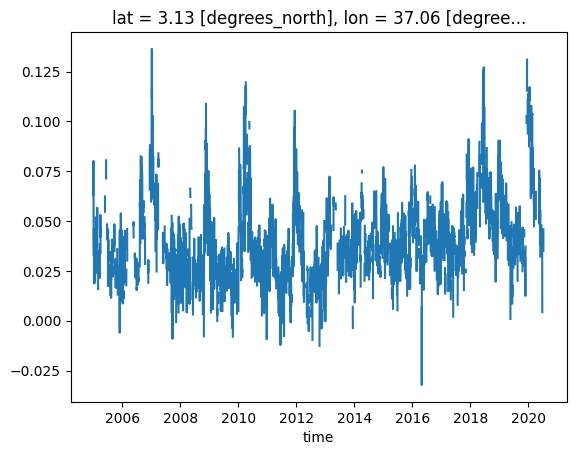

In [25]:
ndvi_1.sel(lat=lat, lon=lon, method="nearest").plot()

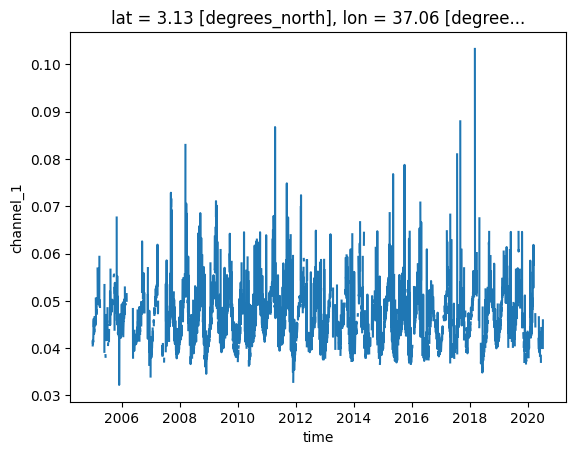

In [22]:
res_xr.channel_1.sel(lat=lat, lon=lon, method="nearest").plot()

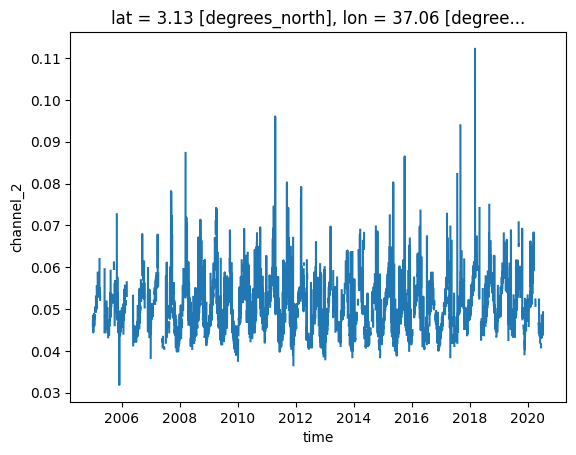

In [24]:
res_xr.channel_2.sel(lat=lat, lon=lon, method="nearest").plot()